In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
!gdown 18KIvMBWD031oDvg0DVebI06SMwKuTp4l

Downloading...
From (original): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l
From (redirected): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l&confirm=t&uuid=4f4161ff-5ef0-4bdd-abba-82fac5d617a9
To: /content/sh3_sc6_y32_x32_imgs.npz
100% 75.5M/75.5M [00:00<00:00, 247MB/s]


In [ ]:
!rm -f /content/dsprites-dataset/*

In [ ]:
dataset_zip = np.load('/content/sh3_sc6_y32_x32_imgs.npz', allow_pickle=True, encoding='latin1')

In [ ]:
imgs = dataset_zip['imgs']

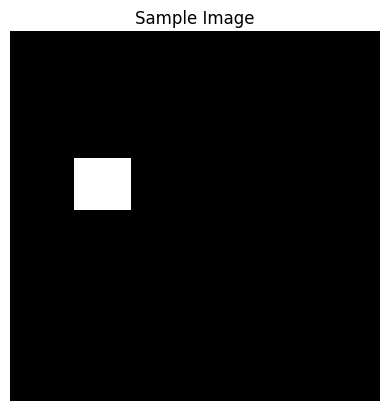

In [ ]:
import matplotlib.pyplot as plt

image_to_show = imgs[10]
plt.imshow(image_to_show, cmap='gray')
plt.title('Sample Image')
plt.axis('off')
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


batch_size = 16

img_transform = transforms.Compose([
    transforms.ToTensor()
])

# Assuming 'imgs' is your NumPy array containing images
class CustomDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        # You might want to convert your image to a tensor and apply any necessary transformations
        if self.transform:
            img = self.transform(img)

        sample = {'image': img}

        return sample

# Use the custom dataset class
custom_dataset = CustomDataset(imgs, transform=img_transform)

# Use the DataLoader with your custom dataset
train_dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# New parameters
latent_dims = 10
num_epochs = 30
batch_size = 64
learning_rate = 1e-3
variational_beta = 1

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc_mu = nn.Linear(in_features=256, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=256, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_dims, out_features=256)
        self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.upconv6 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(x.size(0), 256, 1, 1)
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = F.relu(self.upconv4(x))
        x = F.relu(self.upconv5(x))
        x = torch.sigmoid(self.upconv6(x))
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

kl_divergence = []
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 4096), x.view(-1, 4096), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_divergence.append(kldivergence)
    return recon_loss + variational_beta * kldivergence

vae = VariationalAutoencoder()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)


Number of parameters: 1877909


In [ ]:
!pip install pytorch-fid

In [ ]:
import torch.optim as optim
from torchvision.utils import save_image

optimizer = optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)  # Adjust the learning rate if needed

# Set to training mode
vae.train()
losses=[]
train_loss_avg = []
kl_error_values = []
kl_divergence = []

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 2**12), x.view(-1, 2**12), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_divergence.append(kldivergence)
    return recon_loss + variational_beta * kldivergence


for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for batch_idx, batch in enumerate(train_dataloader):
        image_batch = batch['image'].to(device)

        # VAE reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # Reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        losses.append(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # One step of the optimizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()

        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_avg[-1]:.4f}')


Epoch [1/35], Loss: 546.1005
Epoch [2/35], Loss: 105.7963
Epoch [3/35], Loss: 98.2375
Epoch [4/35], Loss: 98.0261
Epoch [6/35], Loss: 97.8700
Epoch [7/35], Loss: 97.8222
Epoch [8/35], Loss: 97.7843
Epoch [9/35], Loss: 97.7526
Epoch [10/35], Loss: 97.6937
Epoch [11/35], Loss: 97.5839
Epoch [12/35], Loss: 97.5476
Epoch [13/35], Loss: 97.5385
Epoch [14/35], Loss: 97.4081
Epoch [15/35], Loss: 97.3913
Epoch [16/35], Loss: 97.3471
Epoch [17/35], Loss: 97.3168
Epoch [18/35], Loss: 97.2792
Epoch [19/35], Loss: 97.2746
Epoch [20/35], Loss: 97.2303
Epoch [21/35], Loss: 97.2230
Epoch [22/35], Loss: 97.2174
Epoch [23/35], Loss: 97.1685
Epoch [24/35], Loss: 97.1656
Epoch [25/35], Loss: 97.1678
Epoch [26/35], Loss: 97.1286
Epoch [27/35], Loss: 97.1206
Epoch [28/35], Loss: 97.1385
Epoch [29/35], Loss: 97.1010
Epoch [30/35], Loss: 97.1001
Epoch [31/35], Loss: 97.0774
Epoch [32/35], Loss: 97.0735
Epoch [33/35], Loss: 97.0711
Epoch [34/35], Loss: 97.0506
Epoch [35/35], Loss: 97.0391


In [ ]:
kl_divergence_values_np = np.array([value.detach().cpu().numpy() for value in kl_divergence])
kl_divergence_values_np.shape
kl_error_values = []
for epoch in range(len(kl_divergence)):
  test = losses[epoch] + kl_divergence[epoch]
  kl_error_values.append(test)
kl_error_values_np = [value.detach().cpu().numpy() for value in kl_error_values]

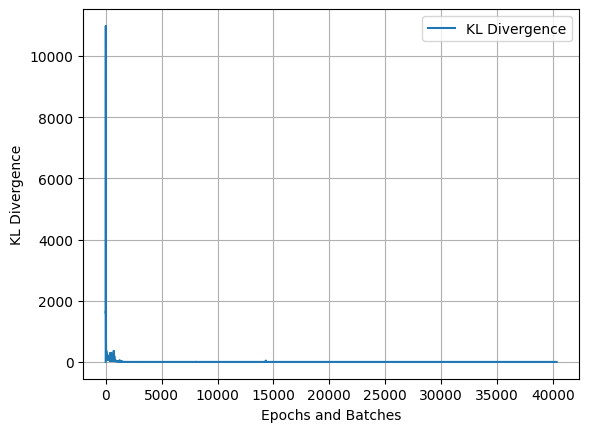

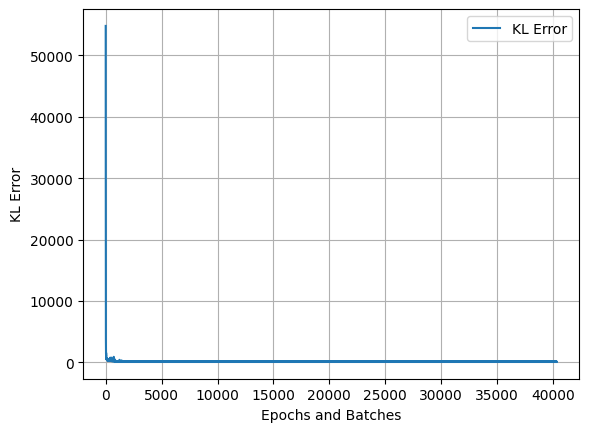

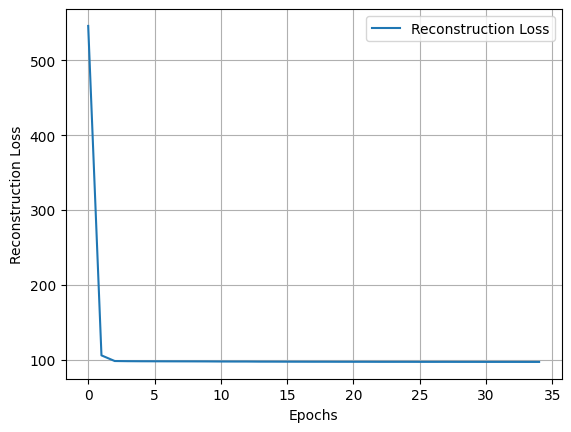

In [ ]:
plt.plot(kl_divergence_values_np, label='KL Divergence')
plt.xlabel('Epochs and Batches')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid('both')
plt.show()

plt.plot(kl_error_values_np, label='KL Error')
plt.xlabel('Epochs and Batches')
plt.ylabel('KL Error')
plt.legend()
plt.grid('both')
plt.show()

plt.plot(train_loss_avg, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid('both')
plt.show()

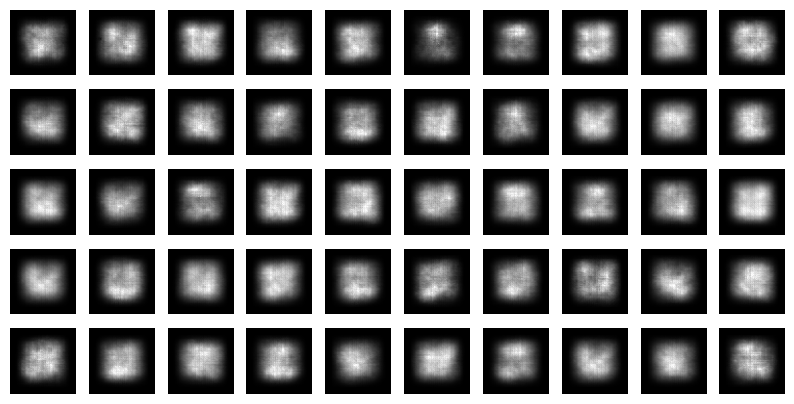

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the VAE to evaluation mode for generating images
vae.eval()

# Generate a 5x10 grid of images
num_generated_rows = 5
num_generated_cols = 10
fig, axs = plt.subplots(num_generated_rows, num_generated_cols, figsize=(10, 5))

with torch.no_grad():
    for i in range(num_generated_rows):
        for j in range(num_generated_cols):
            # Sample from the latent space
            latent_sample = torch.randn(1, latent_dims).to(device)
            # Generate an image using the decoder
            generated_image = vae.decoder(latent_sample)
            generated_image = generated_image.view(64, 64).cpu().numpy()

            axs[i, j].imshow(generated_image, cmap='gray')
            axs[i, j].axis('off')

plt.show()
